# Test Age and Gender Models on a Custom Image
This notebook loads your trained models and predicts age and gender for an image in the `test` folder.

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp

# Model and image config
IMG_SIZE = (128, 128)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_DIR = '../models'
TEST_IMG_DIR = '../test'
MAX_AGE = 116 

# Initialize MediaPipe Face Detector
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# List test images
test_images = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
print('Test images:', test_images)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Test images: ['image.png', 'Newton_3-Year-toddler-photos_0001.jpg', 'Screenshot 2025-08-22 135826.png', 'taylor-swift-2000-d5f08878c5824f51954b3c271dbdb7ea.jpg', 'wadadaadwdas.jpg', 'wadadadawada.jpg', 'Widen-5imzbkUni06_519-babys-first-year.jpg', 'young-boy-smiling-with-grey-shirt.png']


In [2]:
class BaseCNN(nn.Module):
    def __init__(self, output_units=1, task='age'):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * (IMG_SIZE[0] // 8) * (IMG_SIZE[1] // 8), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_units)
        )
        self.task = task

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        if self.task == 'gender':
            x = torch.sigmoid(x)
        return x

In [3]:
# Load the correct model class for ResNet-based models
from torchvision import models
import torch.nn as nn

class ResNetModel(nn.Module):
    def __init__(self, output_units=1, task='age'):
        super().__init__()
        self.resnet = models.resnet18(weights=None)  # weights=None for loading custom weights
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, output_units)
        self.task = task
    def forward(self, x):
        return self.resnet(x)

# Instantiate models
age_model = ResNetModel(output_units=1, task='age')
gender_model = ResNetModel(output_units=1, task='gender')
emotion_model = ResNetModel(output_units=6, task='emotion')

# Load weights
age_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'age_model_resnet.pth'), map_location=DEVICE))
gender_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'gender_model_resnet.pth'), map_location=DEVICE))
emotion_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'emotion_model_resnet.pth' ), map_location=DEVICE))

age_model.eval()
age_model.to(DEVICE)
gender_model.eval()
gender_model.to(DEVICE)
emotion_model.eval()
emotion_model.to(DEVICE)

ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [4]:
# Block 4: Define transforms (should match validation/test transforms used in training)
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Gender label mapping (edit if needed)
gender_map = {0: 'Female', 1: 'Male'}

# Emotion label mapping (edit as needed to match your training classes)
emotion_map = {
    0: 'Angry',
    1: 'Fearful',
    2: 'Happy',
    3: 'Neutral',
    4: 'Sad',
    5: 'Surprise'
}


Running predictions with MediaPipe face detection (age, gender, emotion)...


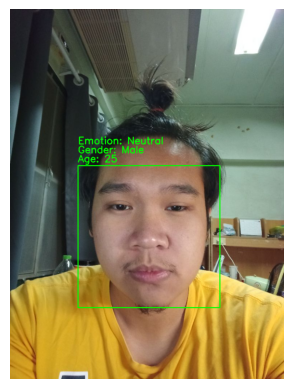

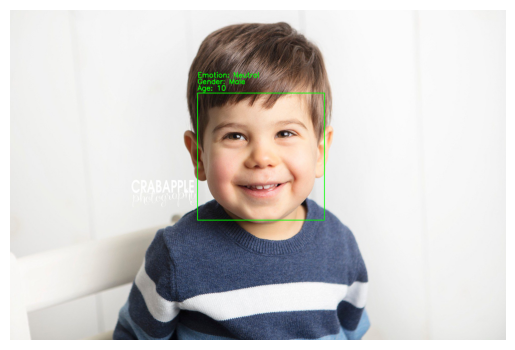

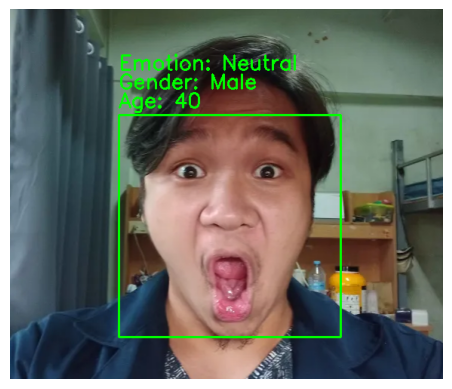

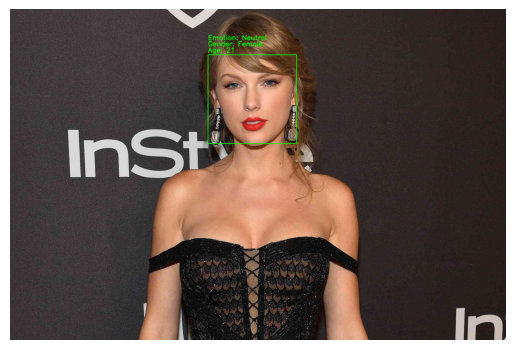

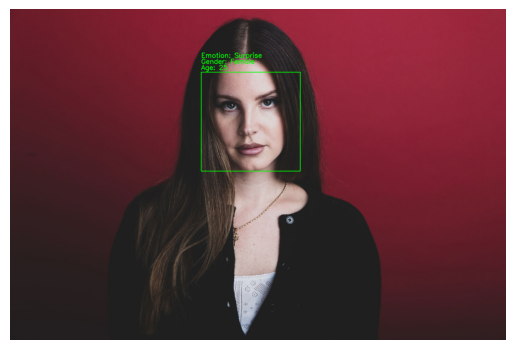

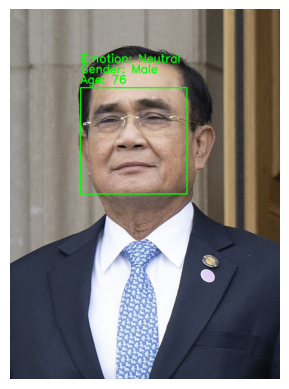

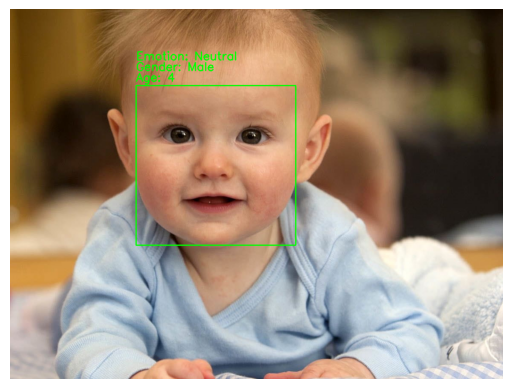

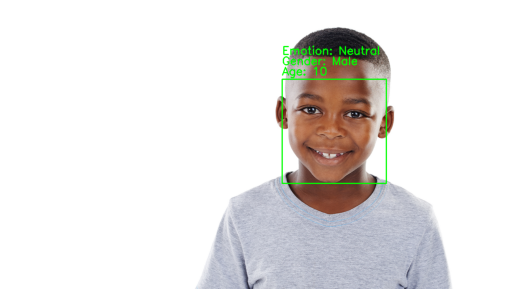

In [5]:
print("\nRunning predictions with MediaPipe face detection (age, gender, emotion)...")

for fname in test_images:
    img_path = os.path.join(TEST_IMG_DIR, fname)

    # Read the image using OpenCV for MediaPipe compatibility
    img_cv2 = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

    # Process the image with MediaPipe
    results = face_detection.process(img_rgb)

    # Check if any faces were detected
    if not results.detections:
        print(f"No face detected in {fname}. Skipping.")
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f'No face detected in {fname}')
        plt.show()
        continue

    # Get the bounding box of the first detected face
    detection = results.detections[0]
    bbox = detection.location_data.relative_bounding_box

    # Calculate pixel coordinates
    h, w, _ = img_cv2.shape
    x, y = int(bbox.xmin * w), int(bbox.ymin * h)
    box_w, box_h = int(bbox.width * w), int(bbox.height * h)

    # Crop the face from the original image
    cropped_face = img_rgb[y:y+box_h, x:x+box_w]

    # Convert to PIL Image and apply your transforms
    pil_face = Image.fromarray(cropped_face)
    img_tensor = test_transform(pil_face).unsqueeze(0).to(DEVICE)

    # Age prediction
    with torch.no_grad():
        age_pred_normalized = age_model(img_tensor).item()
        age_pred = round(age_pred_normalized * MAX_AGE)

    # Gender prediction
    with torch.no_grad():
        gender_pred = gender_model(img_tensor).item()
        gender_idx = int(min(max(round(gender_pred), 0), 1))
        gender_label = gender_map[gender_idx]

    # Emotion prediction
    with torch.no_grad():
        emotion_logits = emotion_model(img_tensor)
        emotion_idx = int(torch.argmax(emotion_logits, dim=1).item())
        emotion_label = emotion_map.get(emotion_idx, 'Unknown')

    # Draw the bounding box and display the result
    cv2.rectangle(img_cv2, (x, y), (x + box_w, y + box_h), (0, 255, 0), 2)
    cv2.putText(img_cv2, f'Age: {age_pred}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.putText(img_cv2, f'Gender: {gender_label}', (x, y - 35), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.putText(img_cv2, f'Emotion: {emotion_label}', (x, y - 60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()